In [1]:
# Parte 1 - creo dataframe
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 

FILENAME = 'monthly_data.csv'
factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})

DATA_INIZIO = '2000-01-01'      # In futuro considerare periodi bull e bear
DATA_FINE = '2023-12-31'        # Quindi utilizzare sub periodi

df = create_df(FILENAME, factors_df['factors'].tolist(), DATA_INIZIO, DATA_FINE) # funzione sua
df['date']=pd.to_datetime(df['date']) 
print(f"DataFrame caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
print(df.columns.tolist())

DataFrame caricato: 1,099,846 righe, 19 colonne
['PERMNO', 'date', 'RET', 'ns', 'me', 'size', 'me_lag', 'ag', 'gp', 'acc', 'bm', 'RF', 'Mkt_RF', 'RET_RF', 'cumret', 'dolvol6', 'ill6', 'volatility', 'beta']


In [2]:
# PARTE 2 - NORMALIZZO CON QUANTILE NORMALIZER

from sklearn.preprocessing import QuantileTransformer

factors_to_normalize = ['ns', 'size', 'ag', 'gp', 'acc', 'bm', 'ill6', 'volatility', 'beta']

# Elimina righe con NaN solo nelle colonne da normalizzare
df_clean = df.dropna(subset=factors_to_normalize)

# Applica Quantile normalization solo ai fattori
scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
df_norm = df_clean.copy()
df_norm[factors_to_normalize] = scaler.fit_transform(df_clean[factors_to_normalize])

print("✅ df normalizzato su fattori:")
df_norm.head()

✅ df normalizzato su fattori:


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,-0.044118,0.552123,19.90625,0.089730,20.82500,0.429226,0.186763,0.098351,0.751966,0.0041,-0.0474,-0.048218,-0.066220,3862.520833,0.868132,0.039530,0.100142
1,10001,2000-02-29,0.015385,0.552123,20.21250,0.090958,19.90625,0.429226,0.186763,0.098351,0.746500,0.0043,0.0245,0.011085,-0.018159,3476.520833,0.875944,0.018688,0.100379
2,10001,2000-03-31,-0.015758,0.619632,19.71200,0.088813,20.21250,0.429226,0.186763,0.098351,0.754909,0.0047,0.0520,-0.020458,-0.015986,3445.854167,0.864058,0.018764,0.102204
3,10001,2000-04-30,0.011719,0.619632,19.94300,0.089905,19.71200,0.429226,0.186763,0.098351,0.751315,0.0046,-0.0640,0.007119,-0.045133,3282.276042,0.822586,0.018568,0.096001
4,10001,2000-05-31,-0.023166,0.619632,19.48100,0.087670,19.94300,0.429226,0.186763,0.098351,0.759141,0.0050,-0.0442,-0.028166,-0.013093,2921.385417,0.850747,0.018772,0.100983


In [3]:
# Parte 3 - inizializzazione della configurazione

# *** ATTENZIONE *** --> PRIMA MODIFICA, HO MESSO TRUE A WEIGHT

remove_outliers = False
inf, sup = None, None
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': True,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}
if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'

factors=factors_df['factors'].to_list() # salva separatamente la lista dei nomi dei fattori 

In [4]:
# Parte 4 - creazione portafogli single criteria e MJ

### COMPUTE SINGLE FACTOR STRATEGIES
portfolios, weighted_portfolios, portfolios_stock_reallocation = compute_factor_strategies(df_norm, MJ_configuration)
        # '2020-06-30': [list of tickers]       # Con pesi, uguale ma 'AAPL': 0.1           # 'AAPL': 2020-06-30': 'P3', '2021-06-30': 'P5'}
        # '2021-06-30': [list of tickers]
        # _ perché non considero weighted_portfolios al momento

### COMPUTE EQUAL WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=False
MJ_portfolios, \
mj_voters, \
MJ_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

portfolios['mj'] = MJ_portfolios['mj']
portfolios_stock_reallocation['mj'] = {}
portfolios_stock_reallocation['mj']['EW_turnover'] = MJ_portfolios_stock_reallocation['mj']

### COMPUTE VALUE WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=True
MJ_weighted_portfolios, \
mj_voters, \
MJ_weighted_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, MJ_configuration)

weighted_portfolios['wmj'] = MJ_weighted_portfolios['wmj']
portfolios_stock_reallocation['wmj'] = {}
portfolios_stock_reallocation['wmj']['VW_turnover'] = MJ_weighted_portfolios_stock_reallocation['wmj']

'''
OUTPUT: 
portfolios = {
  'ns': DataFrame con port1...port10 costruiti su ns,
  'beta': ...,
  'bm': ...,
  ...
  'mj': DataFrame con port1...port10 creati con MJ
}
'''


"\nOUTPUT: \nportfolios = {\n  'ns': DataFrame con port1...port10 costruiti su ns,\n  'beta': ...,\n  'bm': ...,\n  ...\n  'mj': DataFrame con port1...port10 creati con MJ\n}\n"


📊 Rendimento medio mensile PROMETHEE EW – fattore: ag
port1        ➜ rendimento medio = 0.0127
port2        ➜ rendimento medio = 0.0122
port3        ➜ rendimento medio = 0.0132
port4        ➜ rendimento medio = 0.0112
port5        ➜ rendimento medio = 0.0109
port6        ➜ rendimento medio = 0.0108
port7        ➜ rendimento medio = 0.0092
port8        ➜ rendimento medio = 0.0089
port9        ➜ rendimento medio = 0.0068
port10       ➜ rendimento medio = 0.0012
long_short   ➜ rendimento medio = 0.0115

📊 Rendimento medio mensile PROMETHEE VW – fattore: ag
port1        ➜ rendimento medio = 0.0078
port2        ➜ rendimento medio = 0.0105
port3        ➜ rendimento medio = 0.0076
port4        ➜ rendimento medio = 0.0088
port5        ➜ rendimento medio = 0.0071
port6        ➜ rendimento medio = 0.0073
port7        ➜ rendimento medio = 0.0072
port8        ➜ rendimento medio = 0.0075
port9        ➜ rendimento medio = 0.0072
port10       ➜ rendimento medio = 0.0019
long_short   ➜ rendimento med

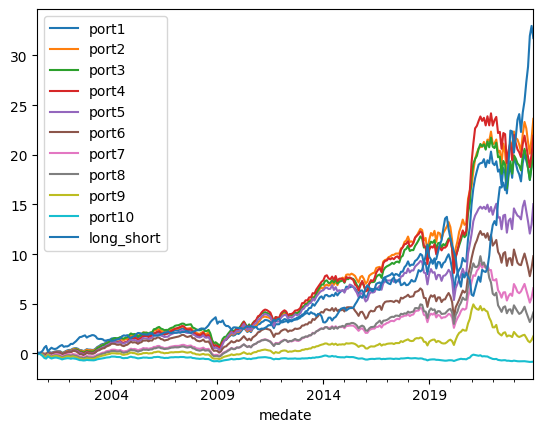

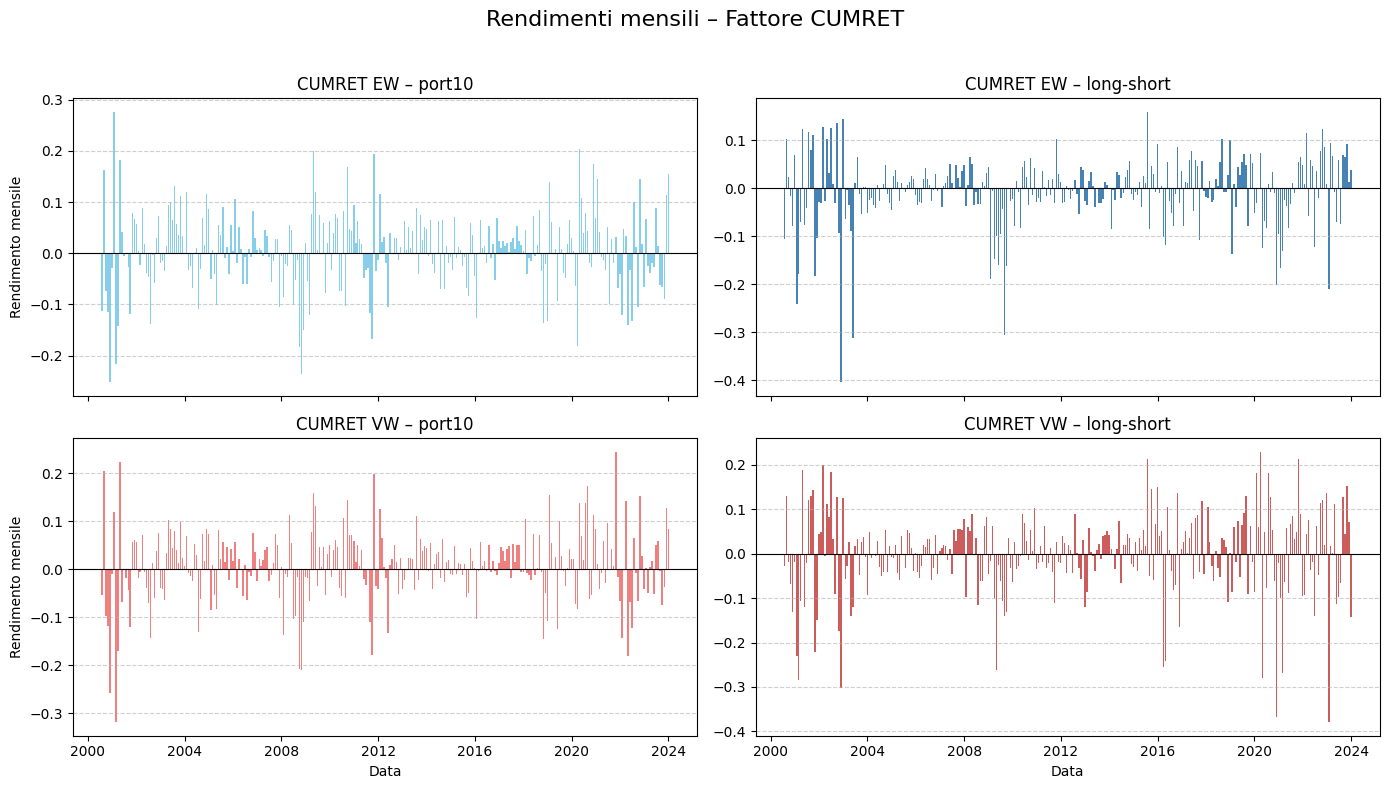

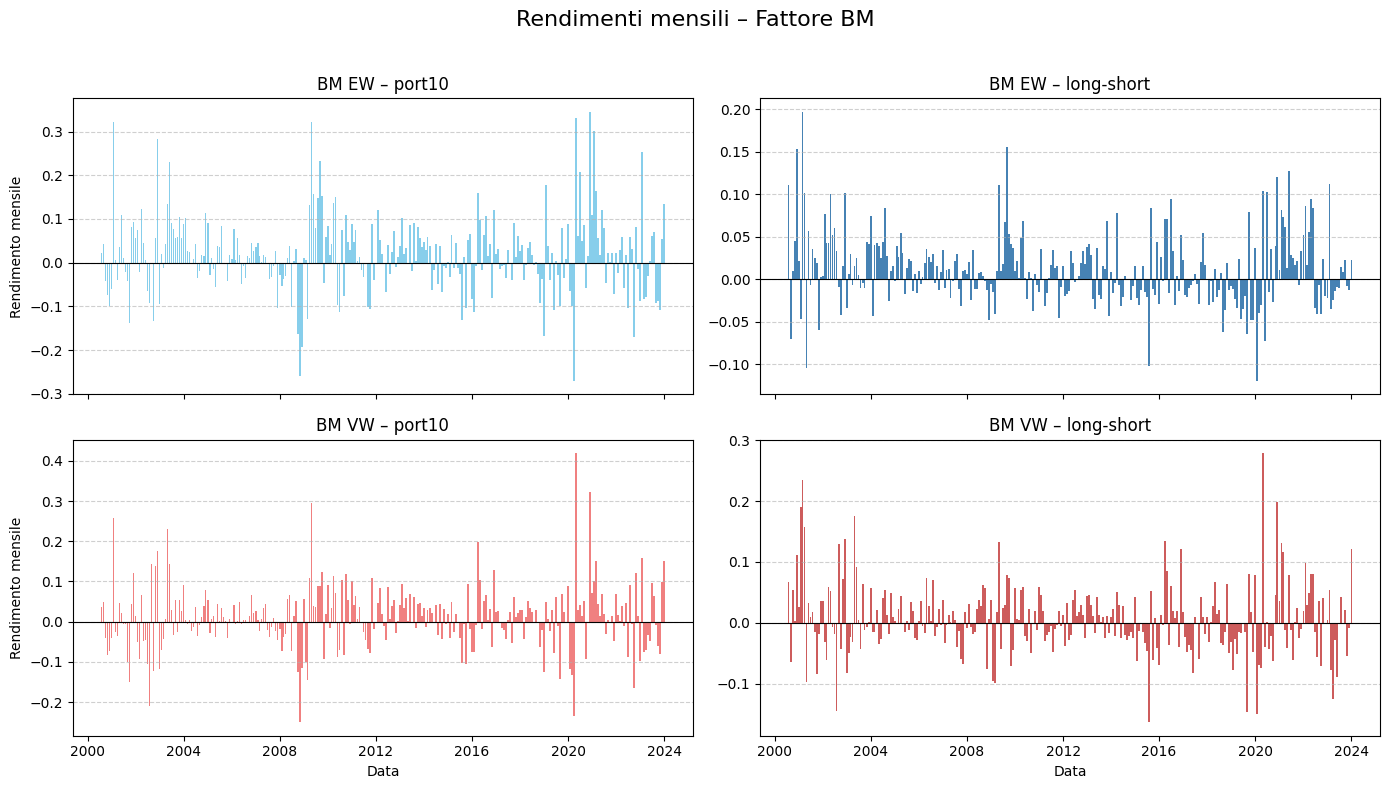

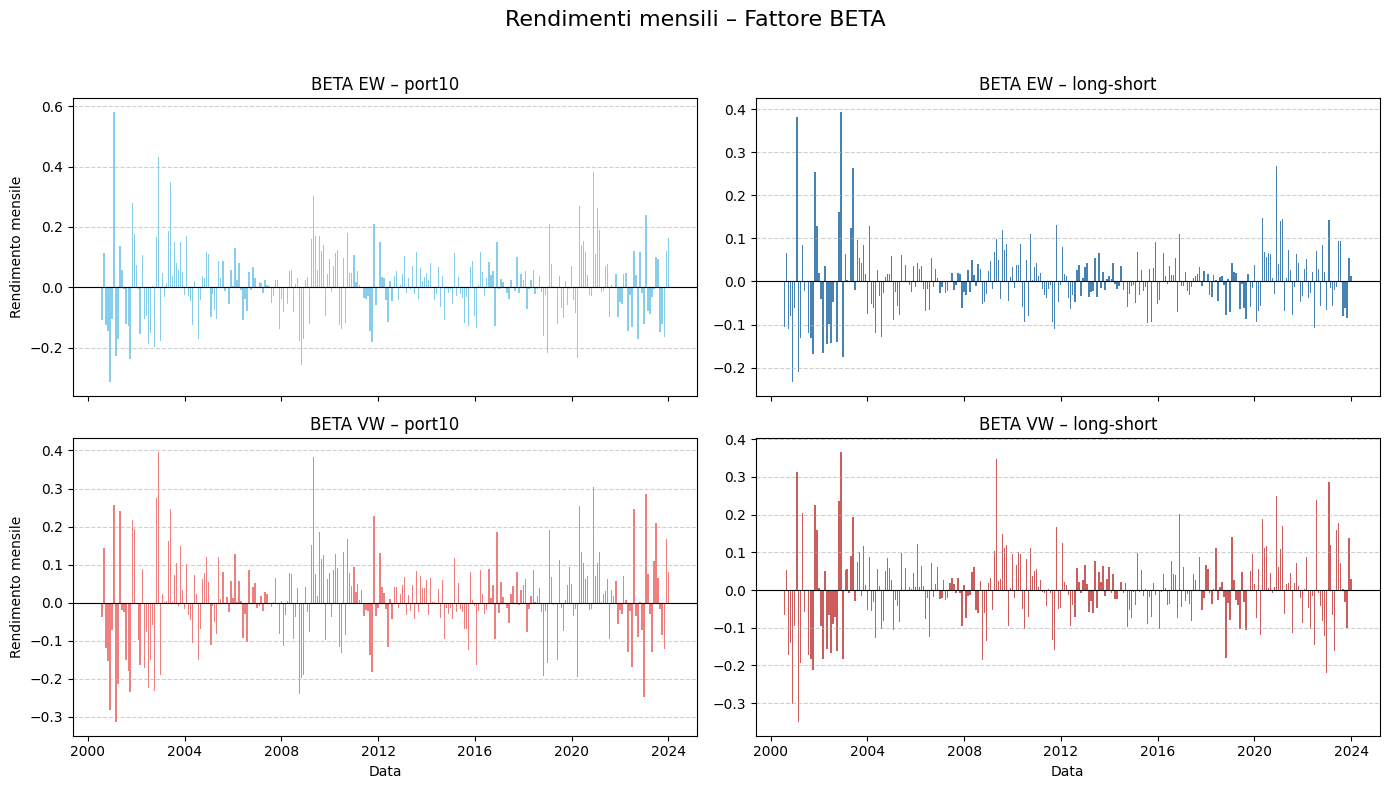

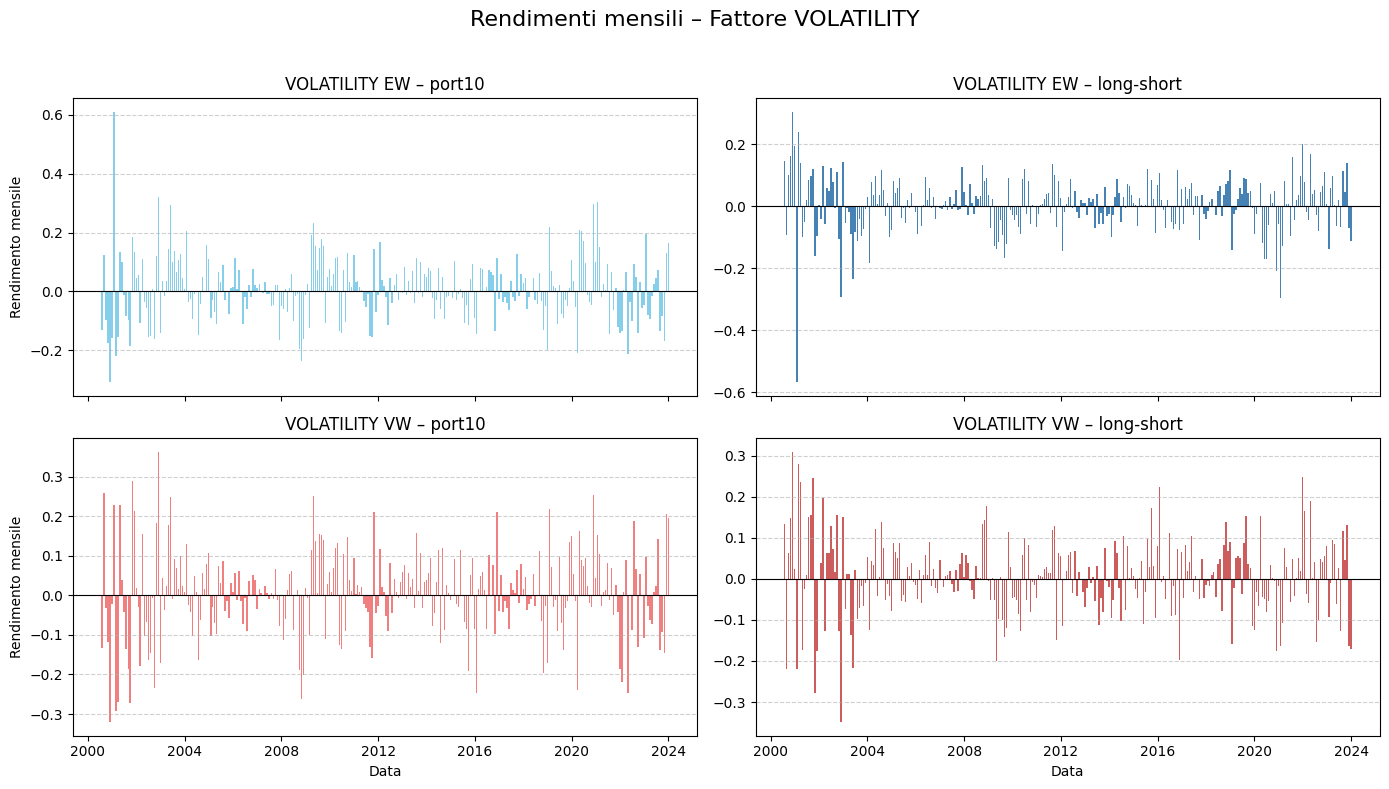

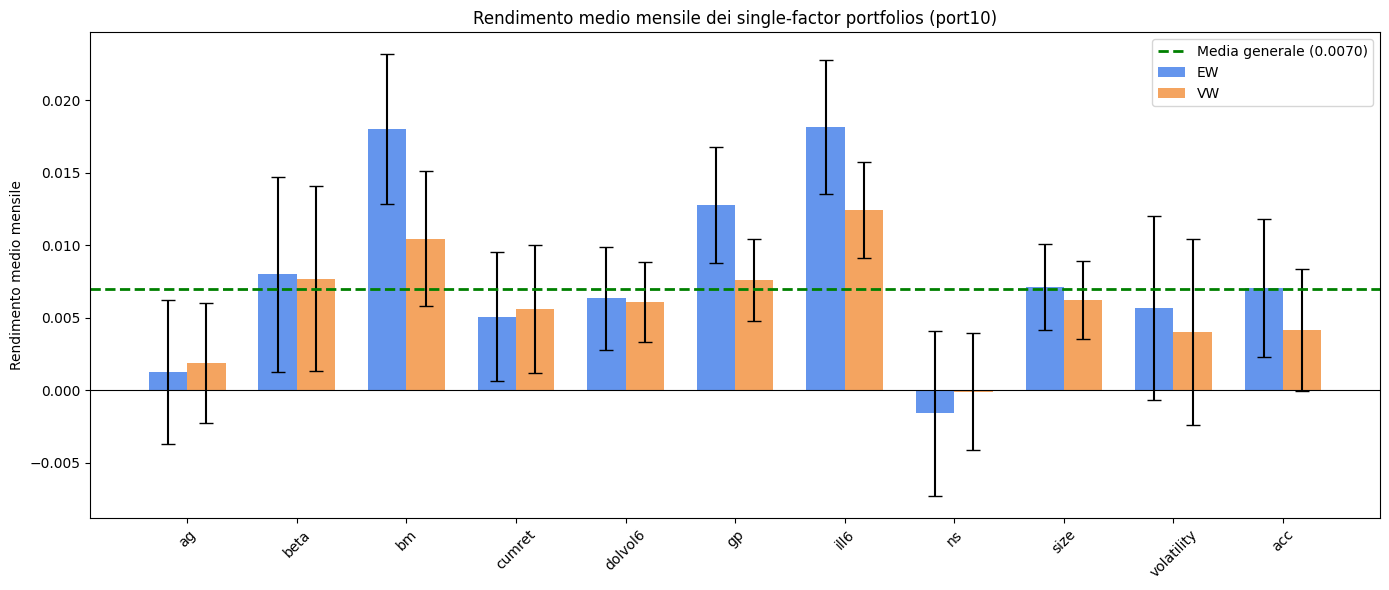

In [ ]:
# Parte 5 - plotto                              # Qua devo modificare il grafico dei mono-fattoriali
# single criteria

######################################################################### RITORNI MEDI ###################################################################
factors_tmp = ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc']

for f in factors_tmp:
    print(f"\n📊 Rendimento medio mensile PROMETHEE EW – fattore: {f}")
    for port in portfolios[f].columns:
        medio = portfolios[f][port].mean()
        print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

    print(f"\n📊 Rendimento medio mensile PROMETHEE VW – fattore: {f}")
    for port in weighted_portfolios[f].columns:
        medio = weighted_portfolios[f][port].mean()
        print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

######################################################################### PICCOLO GRAFICO ###################################################################
import matplotlib.pyplot as plt

factor='ns'                                     # NS casuale, potremmo usare altro
((1+portfolios[factor]).cumprod()-1).plot()

######################################################################### PLOT MENSILE P10 ###################################################################

import matplotlib.pyplot as plt

factors_focusLatex = ['cumret', 'bm', 'beta', 'volatility']

for f in factors_focusLatex:
    fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

    # port10 EW
    axs[0, 0].bar(portfolios[f].index, portfolios[f]['port10'], width=20, color='skyblue')
    axs[0, 0].axhline(0, color='black', linewidth=0.8)
    axs[0, 0].set_title(f'{f.upper()} EW – port10')
    axs[0, 0].grid(True, axis='y', linestyle='--', alpha=0.6)

    # long_short EW
    axs[0, 1].bar(portfolios[f].index, portfolios[f]['long_short'], width=20, color='steelblue')
    axs[0, 1].axhline(0, color='black', linewidth=0.8)
    axs[0, 1].set_title(f'{f.upper()} EW – long-short')
    axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.6)

    # port10 VW
    axs[1, 0].bar(weighted_portfolios[f].index, weighted_portfolios[f]['port10'], width=20, color='lightcoral')
    axs[1, 0].axhline(0, color='black', linewidth=0.8)
    axs[1, 0].set_title(f'{f.upper()} VW – port10')
    axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.6)

    # long_short VW
    axs[1, 1].bar(weighted_portfolios[f].index, weighted_portfolios[f]['long_short'], width=20, color='indianred')
    axs[1, 1].axhline(0, color='black', linewidth=0.8)
    axs[1, 1].set_title(f'{f.upper()} VW – long-short')
    axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.6)

    # Etichette comuni
    fig.suptitle(f'Rendimenti mensili – Fattore {f.upper()}', fontsize=16)
    for ax in axs[1]:
        ax.set_xlabel('Data')
    for ax in axs[:, 0]:
        ax.set_ylabel('Rendimento mensile')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


######################################################################### PLOT STRANO PER SINGLE FACTOR ###################################################################
mean_ew = []
mean_vw = []
stderr_ew = []
stderr_vw = []

mean_ew = []
mean_vw = []
stderr_ew = []
stderr_vw = []

for f in factors_tmp:
    r_ew = portfolios[f]['port10']
    r_vw = weighted_portfolios[f]['port10']
    T_ew = len(r_ew)
    T_vw = len(r_vw)

    mean_ew.append(r_ew.mean())
    mean_vw.append(r_vw.mean())
    stderr_ew.append(r_ew.std() / np.sqrt(T_ew))
    stderr_vw.append(r_vw.std() / np.sqrt(T_vw))

# Calcola media generale dei portafogli single-factor
mean_global = np.mean(mean_ew + mean_vw)

x = np.arange(len(factors))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))

# Barre con errore standard
bars1 = ax.bar(x - width/2, mean_ew, width, yerr=stderr_ew, label='EW', color='cornflowerblue', capsize=5)
bars2 = ax.bar(x + width/2, mean_vw, width, yerr=stderr_vw, label='VW', color='sandybrown', capsize=5)

# Linea orizzontale media globale
ax.axhline(mean_global, color='green', linestyle='--', linewidth=2, label=f'Media generale ({mean_global:.4f})')

# Estetica
ax.set_ylabel('Rendimento medio mensile')
ax.set_xticks(x)
ax.set_xticklabels(factors_tmp, rotation=45)
ax.axhline(0, color='black', linewidth=0.8)
ax.set_title('Rendimento medio mensile dei single-factor portfolios (port10)')
ax.legend()
plt.tight_layout()
plt.show()



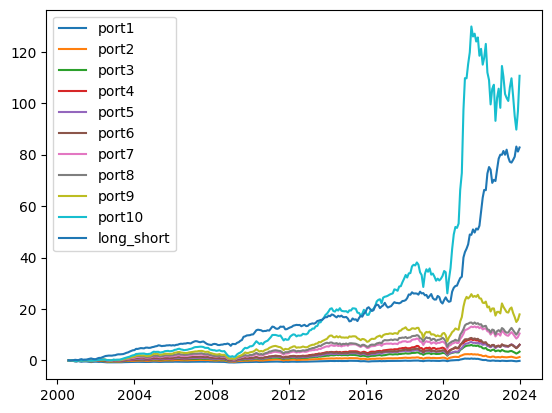

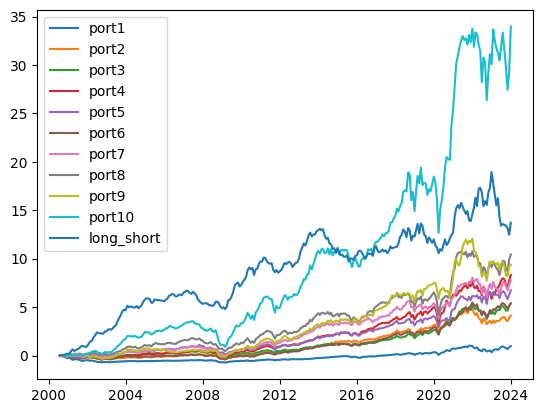

In [6]:
# Plot cumulative returns of EW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['mj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# Plot cumulative returns of VW MJ portfolios 
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+weighted_portfolios['wmj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

In [7]:
# PARTE 6 - COMPUTE EW-VW MCDM STRATEGY

TOPSIS_portfolios, TOPSIS_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=False)
VIKOR_portfolios, VIKOR_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=False)
PROMETHEE_portfolios, PROMETHEE_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=False)

# inserisco EW mcdm in portfolios e reallocation
portfolios['topsis'] = TOPSIS_portfolios # gia' df
portfolios['vikor'] = VIKOR_portfolios
portfolios['promethee'] = PROMETHEE_portfolios

portfolios_stock_reallocation['topsis'] = TOPSIS_portfolios_stock_reallocation
portfolios_stock_reallocation['vikor'] = VIKOR_portfolios_stock_reallocation
portfolios_stock_reallocation['promethee'] = PROMETHEE_portfolios_stock_reallocation

### COMPUTE VW MCDM STRATEGY
TOPSIS_weighted_portfolios, TOPSIS_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration, weighting=True)
VIKOR_weighted_portfolios, VIKOR_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration, weighting=True)
PROMETHEE_weighted_portfolios, PROMETHEE_weighted_portfolios_stock_reallocation = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration, weighting=True)

# inserisco VW mcdm in portfolios e reallocation
weighted_portfolios['wtopsis'] = TOPSIS_weighted_portfolios
weighted_portfolios['wvikor'] = VIKOR_weighted_portfolios
weighted_portfolios['wpromethee'] = PROMETHEE_weighted_portfolios

portfolios_stock_reallocation['wtopsis'] = TOPSIS_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wvikor'] = VIKOR_weighted_portfolios_stock_reallocation
portfolios_stock_reallocation['wpromethee'] = PROMETHEE_weighted_portfolios_stock_reallocation


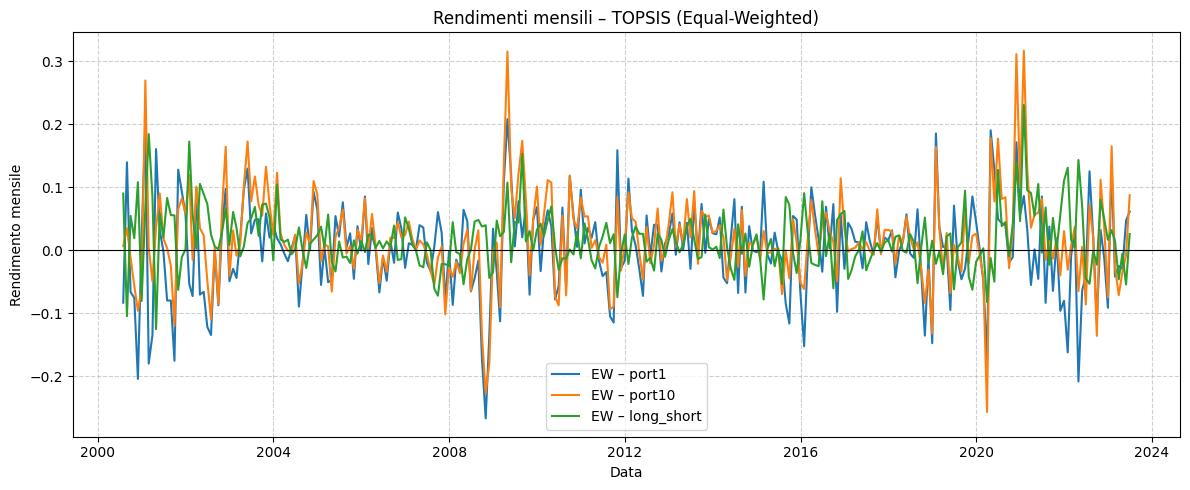

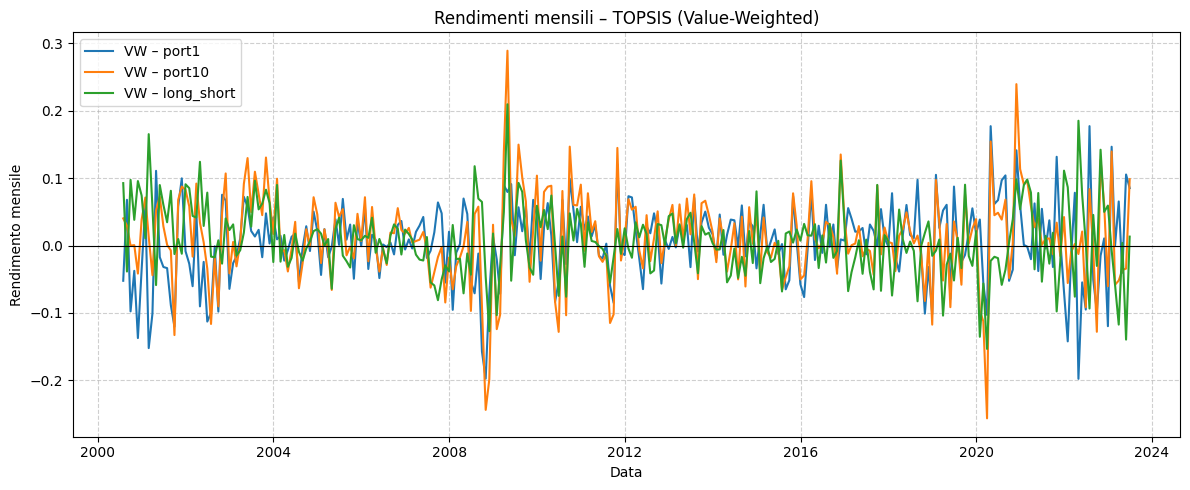


📊 Rendimento medio mensile TOPSIS EW (11 fattori):
port1        ➜ rendimento medio = 0.0025
port2        ➜ rendimento medio = 0.0048
port3        ➜ rendimento medio = 0.0067
port4        ➜ rendimento medio = 0.0076
port5        ➜ rendimento medio = 0.0092
port6        ➜ rendimento medio = 0.0095
port7        ➜ rendimento medio = 0.0113
port8        ➜ rendimento medio = 0.0127
port9        ➜ rendimento medio = 0.0155
port10       ➜ rendimento medio = 0.0189
long_short   ➜ rendimento medio = 0.0164

📊 Rendimento medio mensile TOPSIS VW (11 fattori):
port1        ➜ rendimento medio = 0.0050
port2        ➜ rendimento medio = 0.0075
port3        ➜ rendimento medio = 0.0055
port4        ➜ rendimento medio = 0.0077
port5        ➜ rendimento medio = 0.0099
port6        ➜ rendimento medio = 0.0103
port7        ➜ rendimento medio = 0.0101
port8        ➜ rendimento medio = 0.0102
port9        ➜ rendimento medio = 0.0117
port10       ➜ rendimento medio = 0.0119
long_short   ➜ rendimento medio = 0

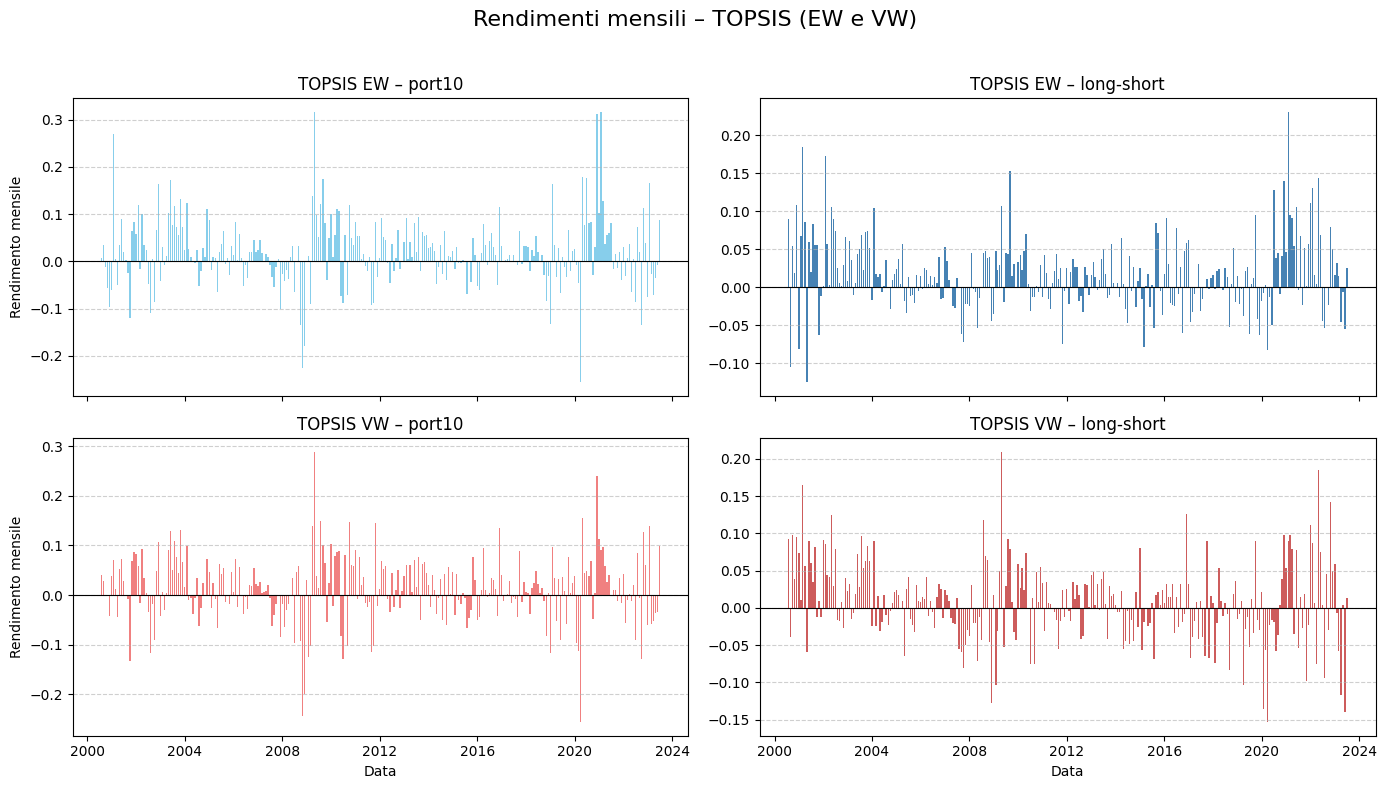

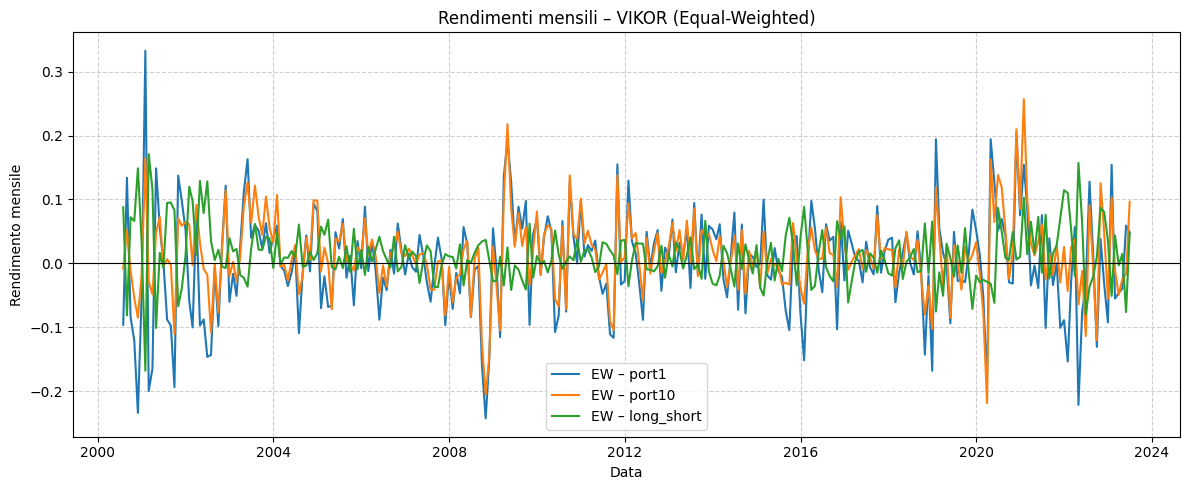

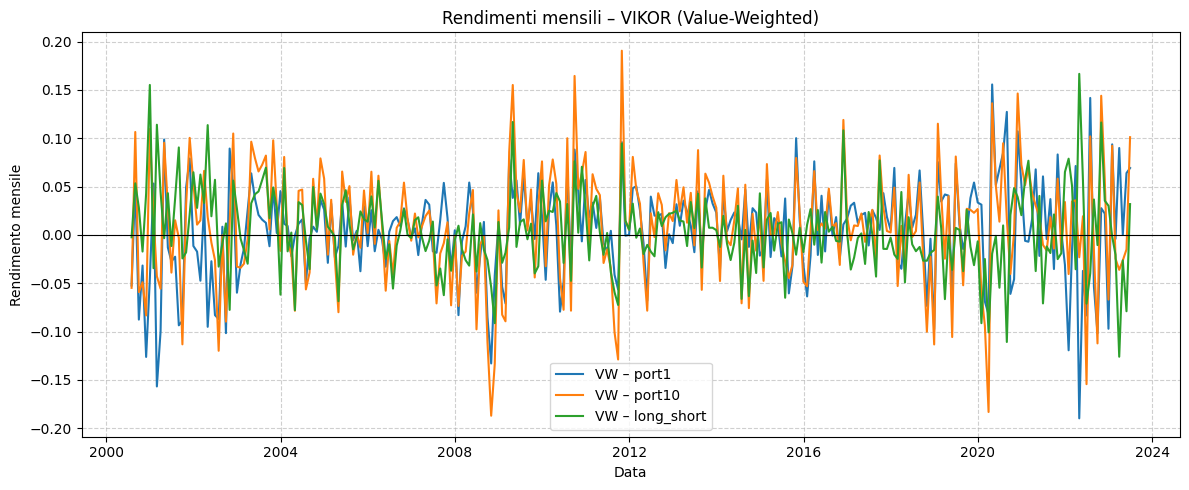


📊 Rendimento medio mensile VIKOR EW (11 fattori):
port1        ➜ rendimento medio = 0.0008
port2        ➜ rendimento medio = 0.0050
port3        ➜ rendimento medio = 0.0078
port4        ➜ rendimento medio = 0.0091
port5        ➜ rendimento medio = 0.0111
port6        ➜ rendimento medio = 0.0111
port7        ➜ rendimento medio = 0.0123
port8        ➜ rendimento medio = 0.0129
port9        ➜ rendimento medio = 0.0140
port10       ➜ rendimento medio = 0.0139
long_short   ➜ rendimento medio = 0.0130

📊 Rendimento medio mensile VIKOR VW (11 fattori):
port1        ➜ rendimento medio = 0.0046
port2        ➜ rendimento medio = 0.0065
port3        ➜ rendimento medio = 0.0083
port4        ➜ rendimento medio = 0.0082
port5        ➜ rendimento medio = 0.0085
port6        ➜ rendimento medio = 0.0090
port7        ➜ rendimento medio = 0.0092
port8        ➜ rendimento medio = 0.0096
port9        ➜ rendimento medio = 0.0082
port10       ➜ rendimento medio = 0.0087
long_short   ➜ rendimento medio = 0.0

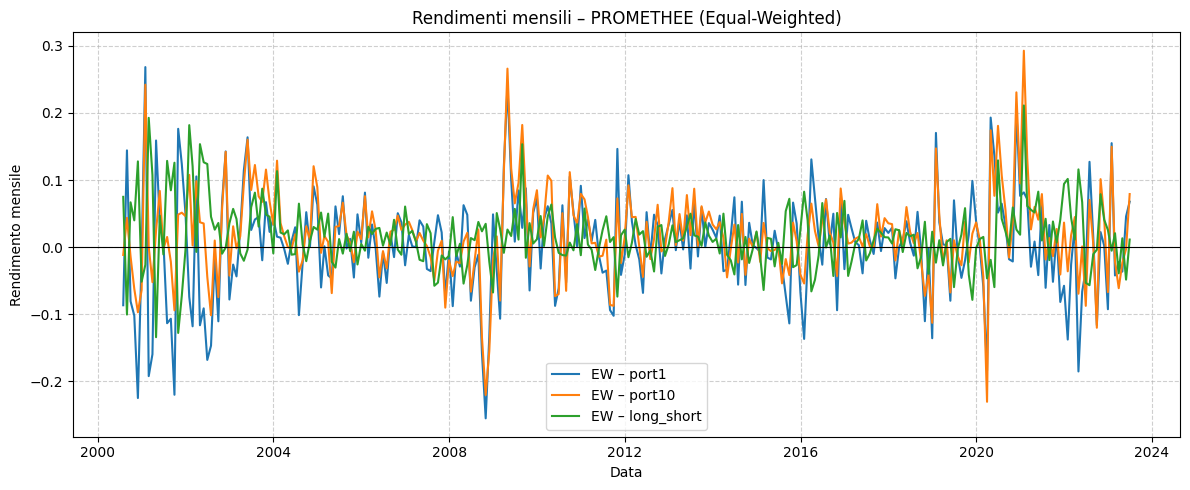

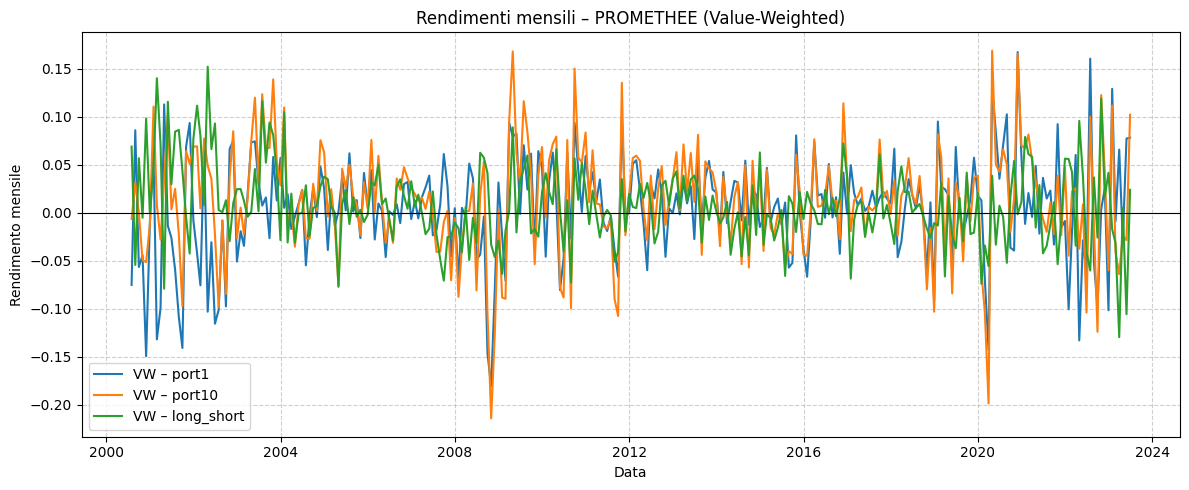


📊 Rendimento medio mensile PROMETHEE EW (11 fattori):
port1        ➜ rendimento medio = 0.0028
port2        ➜ rendimento medio = 0.0054
port3        ➜ rendimento medio = 0.0075
port4        ➜ rendimento medio = 0.0080
port5        ➜ rendimento medio = 0.0088
port6        ➜ rendimento medio = 0.0088
port7        ➜ rendimento medio = 0.0110
port8        ➜ rendimento medio = 0.0123
port9        ➜ rendimento medio = 0.0149
port10       ➜ rendimento medio = 0.0191
long_short   ➜ rendimento medio = 0.0162

📊 Rendimento medio mensile PROMETHEE VW (11 fattori):
port1        ➜ rendimento medio = 0.0045
port2        ➜ rendimento medio = 0.0061
port3        ➜ rendimento medio = 0.0064
port4        ➜ rendimento medio = 0.0093
port5        ➜ rendimento medio = 0.0087
port6        ➜ rendimento medio = 0.0095
port7        ➜ rendimento medio = 0.0109
port8        ➜ rendimento medio = 0.0111
port9        ➜ rendimento medio = 0.0112
port10       ➜ rendimento medio = 0.0123
long_short   ➜ rendimento med

In [40]:
# PARTE 7 - plot degli mcdm

############################################################################### TOPSIS ###############################################################################
port_tmp = ['port1', 'port10', 'long_short']

# --- TOPSIS EW
plt.figure(figsize=(12, 5))
for port in port_tmp:
    plt.plot(portfolios['topsis'][port], label=f"EW – {port}")
plt.title("Rendimenti mensili – TOPSIS (Equal-Weighted)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Rendimento mensile")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- TOPSIS VW
plt.figure(figsize=(12, 5))
for port in port_tmp:
    plt.plot(weighted_portfolios['wtopsis'][port], label=f"VW – {port}")
plt.title("Rendimenti mensili – TOPSIS (Value-Weighted)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Rendimento mensile")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\n📊 Rendimento medio mensile TOPSIS EW (11 fattori):")
for port in portfolios['topsis'].columns:
    medio = portfolios['topsis'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

print("\n📊 Rendimento medio mensile TOPSIS VW (11 fattori):")
for port in weighted_portfolios['wtopsis'].columns:
    medio = weighted_portfolios['wtopsis'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

# -- port10 EW
axs[0, 0].bar(portfolios['topsis'].index, portfolios['topsis']['port10'], width=20, color='skyblue')
axs[0, 0].axhline(0, color='black', linewidth=0.8)
axs[0, 0].set_title('TOPSIS EW – port10')
axs[0, 0].grid(True, axis='y', linestyle='--', alpha=0.6)

# -- long_short EW
axs[0, 1].bar(portfolios['topsis'].index, portfolios['topsis']['long_short'], width=20, color='steelblue')
axs[0, 1].axhline(0, color='black', linewidth=0.8)
axs[0, 1].set_title('TOPSIS EW – long-short')
axs[0, 1].grid(True, axis='y', linestyle='--', alpha=0.6)

# -- port10 VW
axs[1, 0].bar(weighted_portfolios['wtopsis'].index, weighted_portfolios['wtopsis']['port10'], width=20, color='lightcoral')
axs[1, 0].axhline(0, color='black', linewidth=0.8)
axs[1, 0].set_title('TOPSIS VW – port10')
axs[1, 0].grid(True, axis='y', linestyle='--', alpha=0.6)

# -- long_short VW
axs[1, 1].bar(weighted_portfolios['wtopsis'].index, weighted_portfolios['wtopsis']['long_short'], width=20, color='indianred')
axs[1, 1].axhline(0, color='black', linewidth=0.8)
axs[1, 1].set_title('TOPSIS VW – long-short')
axs[1, 1].grid(True, axis='y', linestyle='--', alpha=0.6)

# Etichette comuni
fig.suptitle('Rendimenti mensili – TOPSIS (EW e VW)', fontsize=16)
for ax in axs[1]:
    ax.set_xlabel('Data')
for ax in axs[:, 0]:
    ax.set_ylabel('Rendimento mensile')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


############################################################################### VIKOR ###############################################################################
# --- TOPSIS EW
plt.figure(figsize=(12, 5))
for port in port_tmp:
    plt.plot(portfolios['vikor'][port], label=f"EW – {port}")
plt.title("Rendimenti mensili – VIKOR (Equal-Weighted)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Rendimento mensile")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- TOPSIS VW
plt.figure(figsize=(12, 5))
for port in port_tmp:
    plt.plot(weighted_portfolios['wvikor'][port], label=f"VW – {port}")
plt.title("Rendimenti mensili – VIKOR (Value-Weighted)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Rendimento mensile")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\n📊 Rendimento medio mensile VIKOR EW (11 fattori):")
for port in portfolios['vikor'].columns:
    medio = portfolios['vikor'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

print("\n📊 Rendimento medio mensile VIKOR VW (11 fattori):")
for port in weighted_portfolios['wvikor'].columns:
    medio = weighted_portfolios['wvikor'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

############################################################################### PROMETHEE ###############################################################################
# --- TOPSIS EW
plt.figure(figsize=(12, 5))
for port in port_tmp:
    plt.plot(portfolios['promethee'][port], label=f"EW – {port}")
plt.title("Rendimenti mensili – PROMETHEE (Equal-Weighted)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Rendimento mensile")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# --- TOPSIS VW
plt.figure(figsize=(12, 5))
for port in port_tmp:
    plt.plot(weighted_portfolios['wpromethee'][port], label=f"VW – {port}")
plt.title("Rendimenti mensili – PROMETHEE (Value-Weighted)")
plt.axhline(0, color='black', linewidth=0.8)
plt.ylabel("Rendimento mensile")
plt.xlabel("Data")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

print("\n📊 Rendimento medio mensile PROMETHEE EW (11 fattori):")
for port in portfolios['promethee'].columns:
    medio = portfolios['promethee'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

print("\n📊 Rendimento medio mensile PROMETHEE VW (11 fattori):")
for port in weighted_portfolios['wpromethee'].columns:
    medio = weighted_portfolios['wpromethee'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {medio:.4f}")

In [25]:
print("\n📊 MJ – Rendimenti medi mensili (EW):")
for port in portfolios['mj'].columns:
    media = portfolios['mj'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {media:.4f}")

print("\n📊 MJ – Rendimenti medi mensili (VW):")
for port in weighted_portfolios['wmj'].columns:
    media = weighted_portfolios['wmj'][port].mean()
    print(f"{port:<12} ➜ rendimento medio = {media:.4f}")



📊 MJ – Rendimenti medi mensili (EW):
port1        ➜ rendimento medio = 0.0025
port2        ➜ rendimento medio = 0.0052
port3        ➜ rendimento medio = 0.0074
port4        ➜ rendimento medio = 0.0091
port5        ➜ rendimento medio = 0.0092
port6        ➜ rendimento medio = 0.0091
port7        ➜ rendimento medio = 0.0110
port8        ➜ rendimento medio = 0.0114
port9        ➜ rendimento medio = 0.0129
port10       ➜ rendimento medio = 0.0194
long_short   ➜ rendimento medio = 0.0169

📊 MJ – Rendimenti medi mensili (VW):
port1        ➜ rendimento medio = 0.0040
port2        ➜ rendimento medio = 0.0069
port3        ➜ rendimento medio = 0.0077
port4        ➜ rendimento medio = 0.0093
port5        ➜ rendimento medio = 0.0085
port6        ➜ rendimento medio = 0.0078
port7        ➜ rendimento medio = 0.0092
port8        ➜ rendimento medio = 0.0101
port9        ➜ rendimento medio = 0.0102
port10       ➜ rendimento medio = 0.0145
long_short   ➜ rendimento medio = 0.0105


In [10]:
metodi = list(portfolios.keys())                                                    ## Qua modificare per vedere i vari cosi da mettere nella tabella

best_portfolios = {}

print("Studio dei rendimenti dei portafogli *port10* (EW) per ogni metodo:")
for metodo in metodi:
    df_metodo = portfolios[metodo]

    if 'port10' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha port10.")
        continue

    rendimento_port10 = df_metodo['port10'].mean()

    best_portfolios[metodo] = {
        'portafoglio': 'port10',
        'rendimento_medio': rendimento_port10
    }

for metodo, info in best_portfolios.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui port10 ha avuto il rendimento medio più alto
migliore_assoluto = max(best_portfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
rendimento_top = migliore_assoluto[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior PORT10 è: {metodo_top.upper()} con rendimento medio mensile di {rendimento_top:.4f}")
print("*" * 50)

Studio dei rendimenti dei portafogli *port10* (EW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0012
BETA       ➜ rendimento medio mensile = 0.0080
BM         ➜ rendimento medio mensile = 0.0180
CUMRET     ➜ rendimento medio mensile = 0.0051
DOLVOL6    ➜ rendimento medio mensile = 0.0064
GP         ➜ rendimento medio mensile = 0.0128
ILL6       ➜ rendimento medio mensile = 0.0181
NS         ➜ rendimento medio mensile = -0.0016
SIZE       ➜ rendimento medio mensile = 0.0071
VOLATILITY ➜ rendimento medio mensile = 0.0057
ACC        ➜ rendimento medio mensile = 0.0070
MJ         ➜ rendimento medio mensile = 0.0194
TOPSIS     ➜ rendimento medio mensile = 0.0189
VIKOR      ➜ rendimento medio mensile = 0.0139
PROMETHEE  ➜ rendimento medio mensile = 0.0191
**************************************************
WINNER: Il metodo con il miglior PORT10 è: MJ con rendimento medio mensile di 0.0194
**************************************************


In [11]:
metodi_w = list(weighted_portfolios.keys())

best_wportfolios = {}

print("Studio dei rendimenti dei portafogli *port10* (VW) per ogni metodo:")
for metodo in metodi_w:
    df_metodo = weighted_portfolios[metodo]

    if 'port10' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha port10.")
        continue

    rendimento_port10 = df_metodo['port10'].mean()

    best_wportfolios[metodo] = {
        'portafoglio': 'port10',
        'rendimento_medio': rendimento_port10
    }

for metodo, info in best_wportfolios.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui port10 ha avuto il rendimento medio più alto
migliore_assoluto = max(best_wportfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
rendimento_top = migliore_assoluto[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior PORT10 (VW) è: {metodo_top.upper()} con rendimento medio mensile di {rendimento_top:.4f}")
print("*" * 50)


Studio dei rendimenti dei portafogli *port10* (VW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0019
BETA       ➜ rendimento medio mensile = 0.0077
BM         ➜ rendimento medio mensile = 0.0104
CUMRET     ➜ rendimento medio mensile = 0.0056
DOLVOL6    ➜ rendimento medio mensile = 0.0061
GP         ➜ rendimento medio mensile = 0.0076
ILL6       ➜ rendimento medio mensile = 0.0124
NS         ➜ rendimento medio mensile = -0.0001
SIZE       ➜ rendimento medio mensile = 0.0062
VOLATILITY ➜ rendimento medio mensile = 0.0040
ACC        ➜ rendimento medio mensile = 0.0042
WMJ        ➜ rendimento medio mensile = 0.0145
WTOPSIS    ➜ rendimento medio mensile = 0.0119
WVIKOR     ➜ rendimento medio mensile = 0.0087
WPROMETHEE ➜ rendimento medio mensile = 0.0123
**************************************************
WINNER: Il metodo con il miglior PORT10 (VW) è: WMJ con rendimento medio mensile di 0.0145
**************************************************


In [12]:
# UGUALE MA CON LONG SHORT
metodi = list(portfolios.keys())

best_portfolios_LS = {}

print("Studio dei rendimenti dei portafogli *long_short* (EW) per ogni metodo:")
for metodo in metodi:
    df_metodo = portfolios[metodo]

    if 'long_short' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha long_short.")
        continue

    rendimento_LS = df_metodo['long_short'].mean()

    best_portfolios_LS[metodo] = {
        'portafoglio': 'long_short',
        'rendimento_medio': rendimento_LS
    }

for metodo, info in best_portfolios_LS.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui LS ha avuto il rendimento medio più alto
migliore_assoluto_LS = max(best_portfolios_LS.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top_LS = migliore_assoluto_LS[0]
rendimento_top_LS = migliore_assoluto_LS[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior longshort è: {metodo_top_LS.upper()} con rendimento medio mensile di {rendimento_top_LS:.4f}")
print("*" * 50)

Studio dei rendimenti dei portafogli *long_short* (EW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0115
BETA       ➜ rendimento medio mensile = 0.0012
BM         ➜ rendimento medio mensile = 0.0114
CUMRET     ➜ rendimento medio mensile = -0.0071
DOLVOL6    ➜ rendimento medio mensile = 0.0127
GP         ➜ rendimento medio mensile = 0.0084
ILL6       ➜ rendimento medio mensile = 0.0113
NS         ➜ rendimento medio mensile = 0.0143
SIZE       ➜ rendimento medio mensile = 0.0095
VOLATILITY ➜ rendimento medio mensile = 0.0033
ACC        ➜ rendimento medio mensile = 0.0031
MJ         ➜ rendimento medio mensile = 0.0169
TOPSIS     ➜ rendimento medio mensile = 0.0164
VIKOR      ➜ rendimento medio mensile = 0.0130
PROMETHEE  ➜ rendimento medio mensile = 0.0162
**************************************************
WINNER: Il metodo con il miglior longshort è: MJ con rendimento medio mensile di 0.0169
**************************************************


In [13]:
# UGUALE MA CON LONG SHORT
metodi_w = list(weighted_portfolios.keys())

best_wportfolios_WLS = {}

print("Studio dei rendimenti dei portafogli *long_short* (VW) per ogni metodo:")
for metodo in metodi_w:
    df_metodo = weighted_portfolios[metodo]

    if 'long_short' not in df_metodo.columns:
        print(f"⚠️ Attenzione: {metodo} non ha long_short.")
        continue

    rendimento_WLS = df_metodo['long_short'].mean()

    best_wportfolios_WLS[metodo] = {
        'portafoglio': 'long_short',
        'rendimento_medio': rendimento_WLS
    }

for metodo, info in best_wportfolios_WLS.items():
    print(f"{metodo.upper():<10} ➜ rendimento medio mensile = {info['rendimento_medio']:.4f}")

# Trova il metodo il cui LS ha avuto il rendimento medio più alto
migliore_assoluto_WLS = max(best_wportfolios_WLS.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top_WLS = migliore_assoluto_WLS[0]
rendimento_top_WLS = migliore_assoluto_WLS[1]['rendimento_medio']

print("*" * 50)
print(f"WINNER: Il metodo con il miglior longshort è: {metodo_top_WLS.upper()} con rendimento medio mensile di {rendimento_top_WLS:.4f}")
print("*" * 50)

Studio dei rendimenti dei portafogli *long_short* (VW) per ogni metodo:
AG         ➜ rendimento medio mensile = 0.0059
BETA       ➜ rendimento medio mensile = 0.0018
BM         ➜ rendimento medio mensile = 0.0057
CUMRET     ➜ rendimento medio mensile = -0.0024
DOLVOL6    ➜ rendimento medio mensile = 0.0071
GP         ➜ rendimento medio mensile = 0.0083
ILL6       ➜ rendimento medio mensile = 0.0063
NS         ➜ rendimento medio mensile = 0.0103
SIZE       ➜ rendimento medio mensile = 0.0057
VOLATILITY ➜ rendimento medio mensile = 0.0034
ACC        ➜ rendimento medio mensile = 0.0026
WMJ        ➜ rendimento medio mensile = 0.0105
WTOPSIS    ➜ rendimento medio mensile = 0.0069
WVIKOR     ➜ rendimento medio mensile = 0.0041
WPROMETHEE ➜ rendimento medio mensile = 0.0078
**************************************************
WINNER: Il metodo con il miglior longshort è: WMJ con rendimento medio mensile di 0.0105
**************************************************


In [14]:
# PARTE 9 - Confronto statistico su sharpe-ratio usando bootstrap


def calculate_sharpe_ratio(returns_series, risk_free_rate=0.0):

    '''
    Calcola lo Sharpe Ratio annualizzato.
    Assume returns_series sono rendimenti mensili.
    '''

    mean_return = returns_series.mean() * 12 # Rendimento medio annualizzato
    std_dev = returns_series.std() * np.sqrt(12) # Deviazione standard annualizzata (volatilità)

    annualized_risk_free_rate = risk_free_rate * 12

    if std_dev == 0:
        return np.nan
    return (mean_return - annualized_risk_free_rate) / std_dev


def compute_portfolio_stats(best_portfolios, portfolios_dict):
    risultati = []

    for metodo, info in best_portfolios.items():
        portafoglio = info['portafoglio']
        serie = portfolios_dict[metodo][portafoglio]

        rendimento_medio = serie.mean()
        volatilita = serie.std()
        sharpe = calculate_sharpe_ratio(serie)

        # Calcolo drawdown
        cumulative = (1 + serie).cumprod()
        peak = cumulative.cummax()
        drawdown = (cumulative - peak) / peak
        max_drawdown = drawdown.min()

        risultati.append({
            'Metodo': metodo,
            'Portafoglio': portafoglio,
            'Rendimento medio': rendimento_medio,
            'Volatilità': volatilita,
            'Sharpe Ratio': sharpe,
            'Max Drawdown': max_drawdown
        })


    return pd.DataFrame(risultati)


stats_ew = compute_portfolio_stats(best_portfolios, portfolios)
stats_vw = compute_portfolio_stats(best_wportfolios, weighted_portfolios)

print("Statistiche portafogli Equal Weighted (EW):")
print(stats_ew.round(4))

print("\nStatistiche portafogli Value Weighted (VW):")
print(stats_vw.round(4))



def bootstrap_sharpe_comparison_block(returns1, returns2, num_bootstrap_samples=2000,

    block_size=6, risk_free_rate=0.0):
    """

    Confronta gli Sharpe Ratio di due serie di rendimenti usando il block bootstrap.

    Restituisce la proporzione di volte che Sharpe1 > Sharpe2 (p-value unilaterale).

    Args:

    returns1 (pd.Series): Serie di rendimenti del primo portafoglio.

    returns2 (pd.Series): Serie di rendimenti del secondo portafoglio.

    num_bootstrap_samples (int): Numero di simulazioni bootstrap da eseguire.

    block_size (int): La dimensione del blocco di rendimenti da campionare.

    risk_free_rate (float): Tasso di rendimento risk-free mensile.

    """

    sharpes_diff = []
    n = len(returns1)

    # Calcola il numero di blocchi disponibili
    num_blocks = n // block_size
    if num_blocks == 0:
        print("Errore: la dimensione del blocco è maggiore della lunghezza dei dati.")
        return np.nan


    for _ in range(num_bootstrap_samples):

    # *** MODIFICA: Campionamento con block bootstrap ***
    # 1. Campiona gli INDICI dei blocchi con reinserimento
        block_indices = np.random.choice(num_blocks, size=num_blocks, replace=True)

    # 2. Ricostruisci le serie di rendimenti concatenando i blocchi campionati

        sample1 = np.empty(0)
        sample2 = np.empty(0)
        for idx in block_indices:
            start_idx = idx * block_size
            end_idx = start_idx + block_size
            sample1 = np.concatenate([sample1, returns1.iloc[start_idx:end_idx]])
            sample2 = np.concatenate([sample2, returns2.iloc[start_idx:end_idx]])

        # Assicura che la lunghezza del campione sia esattamente la stessa dell'originale
        sample1 = sample1[:n]
        sample2 = sample2[:n]

        # *** FINE MODIFICA ***

        sharpe1 = calculate_sharpe_ratio(pd.Series(sample1), risk_free_rate)
        sharpe2 = calculate_sharpe_ratio(pd.Series(sample2), risk_free_rate)


        if not np.isnan(sharpe1) and not np.isnan(sharpe2):
            sharpes_diff.append(sharpe1 - sharpe2)


    if not sharpes_diff:
        return np.nan

    p_value_one_sided = np.sum(np.array(sharpes_diff) <= 0) / len(sharpes_diff)

    return p_value_one_sided


# --- Applicazione ---
print("\n--- Confronto Statistico degli Sharpe Ratio (WMJ vs Altri VW) ---")
# Tasso risk-free mensile (assumo 0 per semplicità ) --> giustificare durante tesi
RISK_FREE_MONTHLY = 0.0

wmj_port_name = best_wportfolios['wmj']['portafoglio']
wmj_returns_series = weighted_portfolios['wmj'][wmj_port_name]

for metodo in [k for k in weighted_portfolios.keys() if k != 'wmj']:
    other_port_name = best_wportfolios[metodo]['portafoglio']
    other_returns_series = weighted_portfolios[metodo][other_port_name]

    min_len = min(len(wmj_returns_series), len(other_returns_series))
    wmj_sample_returns = wmj_returns_series.iloc[:min_len]
    other_sample_returns = other_returns_series.iloc[:min_len]

    # Chiamo la funzione
    p_value = bootstrap_sharpe_comparison_block(wmj_sample_returns, other_sample_returns, num_bootstrap_samples=2000, risk_free_rate=RISK_FREE_MONTHLY)

    # Interpretazione del p-value   
    alpha = 0.05 # Livello di significatività

    print(f"\nConfronto WMJ vs {metodo.upper()}:")
    if p_value < alpha:
        print(f"La performance risk-adjusted di WMJ è STATISTICAMENTE SUPERIORE a quella di {metodo.upper()} (p-value = {p_value:.4f})")
    else:
        print(f"Non c'è una differenza statisticamente significativa nella performance risk-adjusted tra WMJ e {metodo.upper()} (p-value = {p_value:.4f})")



# Dai risultati, wmj è tra i portafogli più efficienti (ottimo trade-off rendimento/rischio) 

Statistiche portafogli Equal Weighted (EW):
        Metodo Portafoglio  Rendimento medio  Volatilità  Sharpe Ratio  \
0           ag      port10            0.0012      0.0834        0.0519   
1         beta      port10            0.0080      0.1131        0.2448   
2           bm      port10            0.0180      0.0868        0.7180   
3       cumret      port10            0.0051      0.0748        0.2346   
4      dolvol6      port10            0.0064      0.0597        0.3683   
5           gp      port10            0.0128      0.0674        0.6564   
6         ill6      port10            0.0181      0.0776        0.8103   
7           ns      port10           -0.0016      0.0957       -0.0574   
8         size      port10            0.0071      0.0497        0.4976   
9   volatility      port10            0.0057      0.1067        0.1842   
10         acc      port10            0.0070      0.0798        0.3057   
11          mj      port10            0.0194      0.0724        0.92

In [15]:
from scipy.stats import ttest_rel  # t-test per campioni appaiati

metodi_vw = [k for k in weighted_portfolios.keys() if k != 'wmj']
wmj_port = best_wportfolios['wmj']['portafoglio']  # dovrebbe essere 'port10'
wmj_returns = weighted_portfolios['wmj'][wmj_port]

metodi_rilevanti = []
metodi_irrilevanti = []

print("\n--- Confronto Statistico: t-test tra WMJ e altri metodi (port10 VW) ---")

for metodo in metodi_vw:
    portafoglio = best_wportfolios[metodo]['portafoglio']  # dovrebbe essere 'port10'
    altri_returns = weighted_portfolios[metodo][portafoglio]

    # Allinea lunghezze
    min_len = min(len(wmj_returns), len(altri_returns))
    wmj_sample = wmj_returns.iloc[:min_len]
    altri_sample = altri_returns.iloc[:min_len]

    # t-test a due code per confronto di medie
    stat, p_value = ttest_rel(wmj_sample, altri_sample)

    if p_value < 0.05:
        print(f"\nWMJ vs {metodo.upper()}")
        print(f"t-statistic = {stat:.4f}, p-value = {p_value:.4f}")
        metodi_rilevanti.append(metodo.upper())
    else:
        metodi_irrilevanti.append(metodo.upper())

print(f"\n✅ I metodi {metodi_rilevanti} HANNO una differenza statisticamente significativa nella media dei rendimenti rispetto a WMJ.")
print(f"➖ I metodi {metodi_irrilevanti} NON hanno una differenza statisticamente significativa rispetto a WMJ.")



--- Confronto Statistico: t-test tra WMJ e altri metodi (port10 VW) ---

WMJ vs AG
t-statistic = 4.6495, p-value = 0.0000

WMJ vs CUMRET
t-statistic = 2.8281, p-value = 0.0050

WMJ vs DOLVOL6
t-statistic = 3.6686, p-value = 0.0003

WMJ vs GP
t-statistic = 2.9803, p-value = 0.0031

WMJ vs NS
t-statistic = 5.9711, p-value = 0.0000

WMJ vs SIZE
t-statistic = 3.5947, p-value = 0.0004

WMJ vs VOLATILITY
t-statistic = 2.5182, p-value = 0.0124

WMJ vs ACC
t-statistic = 3.8809, p-value = 0.0001

WMJ vs WVIKOR
t-statistic = 3.3116, p-value = 0.0011

WMJ vs WPROMETHEE
t-statistic = 1.9975, p-value = 0.0468

✅ I metodi ['AG', 'CUMRET', 'DOLVOL6', 'GP', 'NS', 'SIZE', 'VOLATILITY', 'ACC', 'WVIKOR', 'WPROMETHEE'] HANNO una differenza statisticamente significativa nella media dei rendimenti rispetto a WMJ.
➖ I metodi ['BETA', 'BM', 'ILL6', 'WTOPSIS'] NON hanno una differenza statisticamente significativa rispetto a WMJ.


In [16]:
def calculate_sortino_ratio(returns_series, risk_free_rate=RISK_FREE_MONTHLY):
    """
    Calcola il Sortino Ratio annualizzato.
    Assume returns_series sono rendimenti mensili.
    """
    # Rendimenti sotto il target (risk_free_rate mensile)
    excess_returns = returns_series - risk_free_rate
    negative_excess_returns = excess_returns[excess_returns < 0]
    
    downside_deviation = negative_excess_returns.std() * np.sqrt(12) # Annualizza
    
    mean_return = returns_series.mean() * 12 # Annualizza
    annualized_risk_free_rate = risk_free_rate * 12

    if downside_deviation == 0 or np.isnan(downside_deviation): # Gestisci il caso di deviazione standard zero o NaN
        return np.nan
    return (mean_return - annualized_risk_free_rate) / downside_deviation

def find_best_portfolio_by_metric(portfolios_dict, metric_name, metric_calc_func=None, higher_is_better=True):
    best_portfolios_by_metric = {}

    print(f"\n--- Studio dei portafogli VW per: {metric_name.replace('_', ' ').upper()} (solo port10) ---")
    for metodo, df_metodo in portfolios_dict.items():
        metric_values = {}

        if 'port10' not in df_metodo.columns:
            print(f"⚠️ {metodo.upper()} non ha port10 — salto")
            continue

        series = df_metodo['port10']

        if metric_name == 'rendimento_cumulato':
            value = (1 + series).prod() - 1
        elif metric_calc_func:
            value = metric_calc_func(series)
        else:
            raise ValueError(f"La funzione di calcolo per '{metric_name}' non è specificata.")
        
        metric_values['port10'] = value

        best_value = value
        best_portfolios_by_metric[metodo] = {
            'portafoglio': 'port10',
            metric_name: best_value
        }

    for metodo, info in best_portfolios_by_metric.items():
        print(f"{metodo.upper():<10} ➜ port10 con {metric_name.replace('_', ' ')} {info[metric_name]:.4f}")

    # Trova il miglior metodo tra tutti (sempre usando port10)
    if higher_is_better:
        migliore_assoluto = max(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])
    else:
        migliore_assoluto = min(best_portfolios_by_metric.items(), key=lambda x: x[1][metric_name])

    metodo_top = migliore_assoluto[0]
    portafoglio_top = migliore_assoluto[1]['portafoglio']
    value_top = migliore_assoluto[1][metric_name]
    
    print("*" * 50)
    print(f"WINNER: Il miglior metodo VW per {metric_name.replace('_', ' ').upper()} è: {metodo_top.upper()} ➜ port10 con valore {value_top:.4f}")
    print("*" * 50)
    
    return best_portfolios_by_metric


# --- Esecuzione ---

# 1. Miglior portafoglio per Rendimento Cumulato
best_wportfolios_cumulative = find_best_portfolio_by_metric(
    weighted_portfolios, 
    'rendimento_cumulato', 
    higher_is_better=True
)

# 2. Miglior portafoglio per Sharpe Ratio
best_wportfolios_sharpe = find_best_portfolio_by_metric(
    weighted_portfolios, 
    'sharpe_ratio', 
    metric_calc_func=calculate_sharpe_ratio, 
    higher_is_better=True
)

# 3. Miglior portafoglio per Sortino Ratio
best_wportfolios_sortino = find_best_portfolio_by_metric(
    weighted_portfolios, 
    'sortino_ratio', 
    metric_calc_func=calculate_sortino_ratio, 
    higher_is_better=True
)

# Tabella riassuntiva finale:
summary_data = []
for method in weighted_portfolios.keys():
    row = {'Metodo': method.upper()}
    
    if method in best_wportfolios_cumulative:
        row['Port. Cum. Ret.'] = best_wportfolios_cumulative[method]['portafoglio']
        row['Max Cum. Ret.'] = best_wportfolios_cumulative[method]['rendimento_cumulato']
    
    if method in best_wportfolios_sharpe:
        row['Port. Sharpe'] = best_wportfolios_sharpe[method]['portafoglio']
        row['Max Sharpe'] = best_wportfolios_sharpe[method]['sharpe_ratio']
        
    if method in best_wportfolios_sortino:
        row['Port. Sortino'] = best_wportfolios_sortino[method]['portafoglio']
        row['Max Sortino'] = best_wportfolios_sortino[method]['sortino_ratio']
        
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n--- Riepilogo dei Migliori Portafogli per Metrica (VW) ---")
print(summary_df.round(4).to_string()) # to_string() per visualizzare tutte le colonne


--- Studio dei portafogli VW per: RENDIMENTO CUMULATO (solo port10) ---
AG         ➜ port10 con rendimento cumulato -0.1486
BETA       ➜ port10 con rendimento cumulato 0.7639
BM         ➜ port10 con rendimento cumulato 7.2033
CUMRET     ➜ port10 con rendimento cumulato 1.1851
DOLVOL6    ➜ port10 con rendimento cumulato 3.0822
GP         ➜ port10 con rendimento cumulato 5.1674
ILL6       ➜ port10 con rendimento cumulato 20.3835
NS         ➜ port10 con rendimento cumulato -0.5004
SIZE       ➜ port10 con rendimento cumulato 3.3273
VOLATILITY ➜ port10 con rendimento cumulato -0.4084
ACC        ➜ port10 con rendimento cumulato 0.5783
WMJ        ➜ port10 con rendimento cumulato 33.9757
WTOPSIS    ➜ port10 con rendimento cumulato 13.3322
WVIKOR     ➜ port10 con rendimento cumulato 5.7840
WPROMETHEE ➜ port10 con rendimento cumulato 17.7269
**************************************************
WINNER: Il miglior metodo VW per RENDIMENTO CUMULATO è: WMJ ➜ port10 con valore 33.9757
****************

In [17]:
# Parte 11 - Simulazione costi di transazione

# Rendimento lordo mensile del port10 WMJ
rendimento_lordo_mensile = best_wportfolios['wmj']['rendimento_medio']

# Turnover medio del portafoglio port10 WMJ (Value Weighted)
df_turnover = portfolios_stock_reallocation['wmj']
df_vw = df_turnover['VW_turnover']
turnover_medio = df_vw[df_vw['portfolio'] == 10.0]['VW_turnover'].values[0]

# Costo per transazione (es. 0.2%)
costo_transazione = 0.002

# Impatto medio mensile dei costi di transazione
impatto_costo = turnover_medio * costo_transazione

# Rendimento netto stimato
rendimento_netto_mensile = rendimento_lordo_mensile - impatto_costo

print(f"Turnover medio mensile stimato: {turnover_medio:.4f}")
print(f"Rendimento lordo WMJ: {rendimento_lordo_mensile:.4f}")
print(f"Rendimento netto stimato WMJ dopo costi: {rendimento_netto_mensile:.4f}")
print(f"Penalizzazione dovuta a costi: {impatto_costo:.4f}")


Turnover medio mensile stimato: 0.3452
Rendimento lordo WMJ: 0.0145
Rendimento netto stimato WMJ dopo costi: 0.0139
Penalizzazione dovuta a costi: 0.0007



DataFrame normalizzato:
             Rendimento medio  Volatilità  Sharpe Ratio  Max Drawdown
Metodo                                                              
dolvol6             0.000000    1.000000      0.000000      0.000000
wmj                 1.000000    0.254003      1.000000      0.223442
wtopsis             0.685244    0.000000      0.458743      1.000000
wpromethee          0.736619    0.452295      0.786924      0.495059


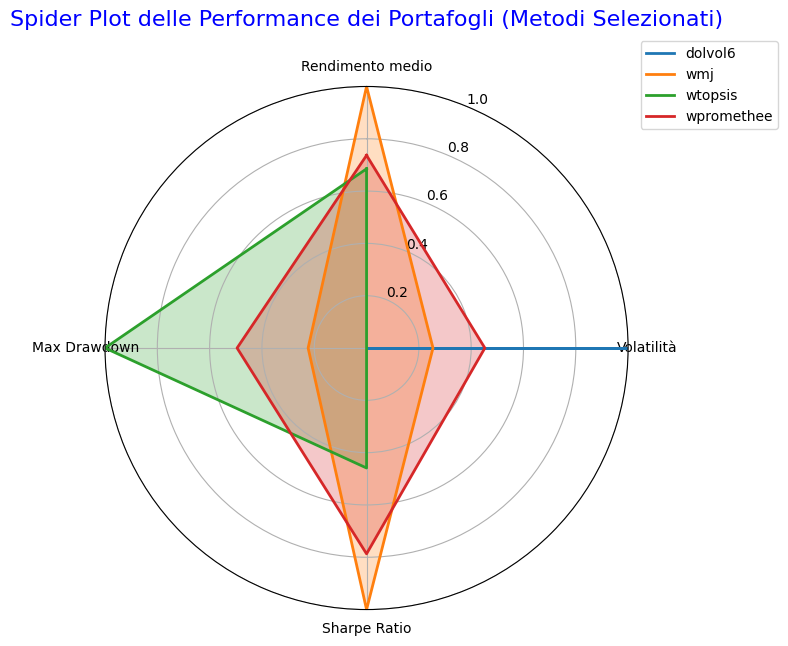

In [18]:
# Parte 12- spider plot che non e' neanche sto gran vedere

import numpy as np
import matplotlib.pyplot as plt

def plot_spider(df_stats, metodi_spider_plot):
    df_filtered_stats = df_stats[df_stats['Metodo'].isin(metodi_spider_plot)].set_index('Metodo')

    categories = ['Rendimento medio', 'Volatilità', 'Sharpe Ratio', 'Max Drawdown']

    normalized_df = pd.DataFrame(index=df_filtered_stats.index, columns=categories)

    for col in categories:
        if col in ['Rendimento medio', 'Sharpe Ratio']:
            min_val = df_filtered_stats[col].min()
            max_val = df_filtered_stats[col].max()
            normalized_df[col] = (df_filtered_stats[col] - min_val) / (max_val - min_val) if (max_val - min_val) != 0 else 0
        elif col in ['Volatilità', 'Max Drawdown']:
            min_val = df_filtered_stats[col].min()
            max_val = df_filtered_stats[col].max()
            if (max_val - min_val) != 0:
                normalized_df[col] = 1 - (df_filtered_stats[col] - min_val) / (max_val - min_val)
            else:
                normalized_df[col] = 0

    normalized_df = normalized_df.fillna(0).clip(0, 1)
    print("\nDataFrame normalizzato:\n", normalized_df)

    labels = np.array(categories)
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i, row in normalized_df.iterrows():
        values = row.tolist()
        values += values[:1]

        ax.plot(angles, values, linewidth=2, linestyle='solid', label=i)
        ax.fill(angles, values, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"])
    ax.set_ylim(0, 1)

    plt.title('Spider Plot delle Performance dei Portafogli (Metodi Selezionati)', size=16, color='blue', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    plt.show()

metodi_spider_plot = ['dolvol6', 'wmj', 'wtopsis', 'vikor', 'wpromethee']
plot_spider(stats_vw, metodi_spider_plot )

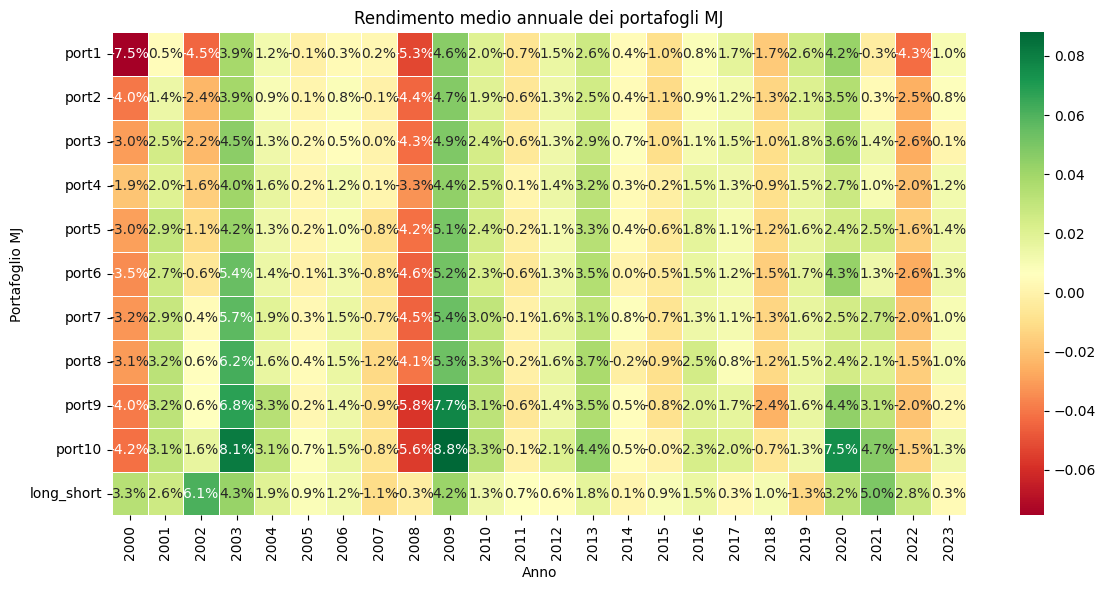

In [19]:
import seaborn as sns

df_mj = portfolios['mj'].copy()
df_mj.index = pd.to_datetime(df_mj.index)

mj_annual_returns = df_mj.resample('Y').mean()
mj_annual_returns.index = mj_annual_returns.index.year

# 4. Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(mj_annual_returns.T, cmap="RdYlGn", annot=True, fmt=".1%", linewidths=.5)
plt.title("Rendimento medio annuale dei portafogli MJ")
plt.xlabel("Anno")
plt.ylabel("Portafoglio MJ")
plt.tight_layout()
plt.show()


In [21]:
def calculate_rolling_sortino_ratio(excess_returns, window=36, target_return=0, annualization_factor=12):
   """
   Calculate rolling Sortino ratio with specified window length.
  
   Parameters:
   excess_returns (pd.Series): Monthly excess returns
   window (int): Rolling window size in months, defaults to 36
   target_return (float): Minimum acceptable return, typically 0
   annualization_factor (int): 12 for monthly data
  
   Returns:
   pd.Series: Rolling Sortino ratio
   """
   # Function to calculate Sortino ratio for a single window
   def sortino_for_window(window_returns):
       # Isolate downside returns
       downside_returns = window_returns.copy()
       downside_returns[downside_returns > target_return] = 0
      
       # Calculate downside deviation
       downside_deviation = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(annualization_factor)
      
       # Calculate annualized return
       annualized_return = window_returns.mean() * annualization_factor
      
       # Return Sortino ratio (handle division by zero)
       if downside_deviation == 0:
           return np.nan
       return annualized_return / downside_deviation
  
   # Apply rolling calculation
   rolling_sortino = excess_returns.rolling(window=window).apply(sortino_for_window, raw=False)
  
   return rolling_sortino

def calculate_rolling_maximum_drawdown(excess_returns, window=36):
   """
   Calculate rolling maximum drawdown with specified window length.
  
   Parameters:
   excess_returns (pd.Series): Monthly excess returns
   window (int): Rolling window size in months, defaults to 36
  
   Returns:
   pd.Series: Rolling maximum drawdown (as positive values)
   """
   # Function to calculate max drawdown for a single window
   def max_drawdown_for_window(window_returns):
       # Convert returns to cumulative returns
       cumulative_returns = (1 + window_returns).cumprod()
      
       # Calculate running maximum
       running_max = cumulative_returns.cummax()
      
       # Calculate drawdown
       drawdown = (cumulative_returns / running_max) - 1
      
       # Find maximum drawdown
       max_drawdown = drawdown.min()
      
       # Return as positive value
       return abs(max_drawdown)
  
   # Apply rolling calculation
   rolling_mdd = excess_returns.rolling(window=window).apply(max_drawdown_for_window, raw=False)
  
   return rolling_mdd

def compute_portfolio_performance(df, window_size=36):
   """
   Compute rolling performance metrics for a portfolio
  
   Parameters:
   -----------
   df: DataFrame containing columns:
   port_excess :  Time series of portfolio excess returns
   mkt_excess :  Time series of market excess returns
   window_size : int
       Size of the rolling window in months (default: 36 for 3 years)
      
   Returns:
   --------
   pandas.DataFrame
       DataFrame with rolling performance metrics
   """
   # Ensure all inputs are aligned and have the same index
   data=df.copy()


   # Calculate active returns (portfolio excess returns minus benchmark excess returns)
   data['port_minus_mkt'] = data['port_excess'] - data['mkt_excess']
  
   # Calculate rolling performance metrics
   performance = pd.DataFrame(index=data.index)
  
   # Mean return (annualized)
   performance['Av_ret'] = data['port_excess'].rolling(window=window_size).mean() * 12
  
   # Volatility (annualized)
   performance['Vol_ret'] = data['port_excess'].rolling(window=window_size).std() * np.sqrt(12)
  
   # Sharpe ratio (annualized)
   performance['Sharpe_ratio'] = (
       data['port_excess'].rolling(window=window_size).mean() /
       data['port_excess'].rolling(window=window_size).std()
   ) * np.sqrt(12)
  
   # For beta calculation, need rolling covariance and variance
   def rolling_beta(df, window):
       cov = df['port_excess'].rolling(window=window).cov(df['mkt_excess'])
       var = df['mkt_excess'].rolling(window=window).var()
       return cov / var
  
   performance['beta'] = rolling_beta(data, window_size)
  
   # Treynor ratio (annualized)
   raw_treynor = (
       data['port_excess'].rolling(window=window_size).mean() /
       (performance['beta'])
   ) * 12


   lower_bound = np.percentile(raw_treynor.dropna(), 5)
   upper_bound = np.percentile(raw_treynor.dropna(), 95)
  
   performance['Treynor_ratio'] = raw_treynor.clip(lower=lower_bound, upper=upper_bound)
  
   # Information ratio (annualized) - FIXED
   # Uses port_minus_mkt (active returns) to calculate the Information Ratio
   active_return_mean = data['port_minus_mkt'].rolling(window=window_size).mean()
   tracking_error = data['port_minus_mkt'].rolling(window=window_size).std()
   performance['Information_ratio'] = (active_return_mean / tracking_error) * np.sqrt(12)
  
   # Jensen's alpha (annualized)
   performance['alpha'] = (
       data['port_excess'].rolling(window=window_size).mean() -
       performance['beta'] * data['mkt_excess'].rolling(window=window_size).mean()
   ) * 12
  
   # Drop NaN values from the initial window period
   #performance = performance.dropna()
   performance['Sortino_ratio'] = calculate_rolling_sortino_ratio(data['port_excess'], window=window_size)
   performance['Max_Drawdown'] = calculate_rolling_maximum_drawdown(data['port_excess'], window=window_size)
  
   return performance

def identify_market_regimes(returns, window=12):
   """
   Identify bullish and bearish market regimes based on cumulative returns
   over the specified window.
  
   Definition:
   - Bull market: When cumulative returns over the past window months > 0
   - Bear market: When cumulative returns over the past window months <= 0
  
   Parameters:
   -----------
   returns : pandas.Series or numpy.ndarray
       Time series of monthly market returns
   window : int, default 24
       Number of months to look back for calculating cumulative returns
      
   Returns:
   --------
   pandas.DataFrame
       DataFrame with columns:
       - 'returns': original returns
       - 'cum_returns': cumulative returns over the specified window
       - 'regime': market regime (1 for bullish, -1 for bearish)
   """
   import numpy as np
   import pandas as pd
  
   # Convert to pandas Series if numpy array
   if isinstance(returns, np.ndarray):
       returns = pd.Series(returns)
  
   # Calculate rolling cumulative returns over the specified window
   rolling_cum_returns = np.zeros_like(returns)
  
   for i in range(len(returns)):
       # For each point, calculate cumulative returns over the past 'window' months
       start_idx = max(0, i - window + 1)
       if i >= window - 1:  # We have enough data for a full window
           rolling_cum_returns[i] = (1 + returns.iloc[start_idx:i+1]).prod() - 1
       else:  # Not enough data for a full window, use all available data
           rolling_cum_returns[i] = (1 + returns.iloc[0:i+1]).prod() - 1
  
   # Determine market regime
   # Bull market: cumulative returns > 0
   # Bear market: cumulative returns <= 0
   regime = np.ones_like(returns)  # Initialize as bull market
   regime[rolling_cum_returns <= 0.0] = -1  # Bear market
  
   # Create output DataFrame
   result = pd.DataFrame({
       'returns': returns,
       'cum_returns': rolling_cum_returns,
       'regime': regime
   })
  
   return result

def compare_bull_bear_market_indicators(data, window_size=36,port='long_short',regime_window=12):
   """
   Compare multiple investment strategies using Treynor ratio and other metrics
  
   Parameters:
   -----------
   data: Dictionary with portfolio and market excess returns ('mkt_excess', 'port_excess')
   window_size : window for performance
   regime window: window for market regime
   port: type of portfolio
  
   Returns:
   --------
   dict
       Dictionary containing performance metrics for each strategy and comparison statistics
   """
  
   perf = compute_portfolio_performance(
       data,
       window_size=window_size
   )
  
   # Create comparison dataframe for key metrics
   perf_names=perf.columns


   # 0. Performance during different market conditions
   # Define bull/bear markets (simplistic approach using rolling returns)
   regime_res=identify_market_regimes(data['mkt_excess'],
                                      window=regime_window)
   bull_market=regime_res['regime']==1
   bear_market=regime_res['regime']==-1


  
  
   comparison = {}
   for PI in perf_names:
       comparison[PI]={}
       # 1. Average Treynor ratio over the entire period
       comparison[PI][f'avg']  =  perf[PI].mean()
       comparison[PI][f'bull'] = perf.loc[bull_market, PI].mean()
       comparison[PI][f'bear'] = perf.loc[bear_market, PI].mean()
  
  
  
  
   return {
       'detailed_metrics': perf,
       'comparison': comparison
   }


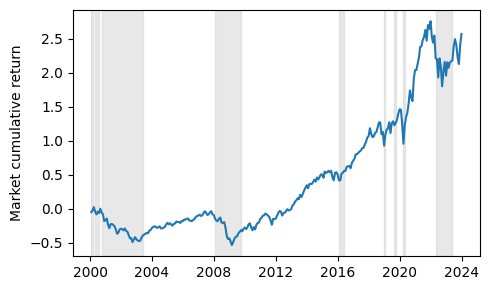

In [22]:
## DEFINIAMO QUALCHE PARAMETRO ED IL RENDIMENTO DI MERCATO (=bull/bear)
## Intervallo ribassista (se array >=2) --> rettangolo grigio, basato sul rendimento cumulato

mkt_rf_df= df[['date','Mkt_RF']].drop_duplicates()
mkt_rf_df = mkt_rf_df.rename(columns={'date':'medate'})
mkt_rf_df = mkt_rf_df.reset_index(drop=True)
mkt_rf_df=mkt_rf_df.sort_values(by='medate')

port='long_short'
window=36
regime_window=12

######################
# PLOT MARKET CUMULATIVE RETURNS AND REGIMES
######################

fig, ax = plt.subplots(figsize=(5, 3))

#### PLOT MARKET REGIMES IN TIME
df_mkt=mkt_rf_df.copy()
regime_window=12
df_mkt[['cum_returns','regime']]=identify_market_regimes(df_mkt['Mkt_RF'],regime_window)[['cum_returns','regime']]


# Find regions with at least two consecutive regime = -1
consecutive_regions = []
start_idx = None
for i in range(len(df_mkt)):
   # Start of a new potential region
   if df_mkt['regime'].iloc[i] == -1.0 and start_idx is None:
       start_idx = i
  
   # End of a potential region
   elif df_mkt['regime'].iloc[i] != -1.0 and start_idx is not None:
       # Check if we have at least 2 consecutive -1 values
       if i - start_idx >= 2:
           consecutive_regions.append((start_idx, i-1))
       start_idx = None
  
   # Handle the last region if it extends to the end of the data
   if i == len(df_mkt) - 1 and start_idx is not None:
       if i - start_idx >= 1:  # At least 2 points total
           consecutive_regions.append((start_idx, i))


# Add background shadowing for the consecutive regions
for start, end in consecutive_regions:
   start_date = df_mkt['medate'].iloc[start]
   end_date = df_mkt['medate'].iloc[end]
   ax.axvspan(start_date, end_date, color='lightgrey', alpha=0.5, label='bear market')


ax.plot(df_mkt['medate'], ((1+df_mkt['Mkt_RF']).cumprod()-1),label='market cumulative')

#plt.title('Rolling Sharpe Ratio: EW vs VW')
ax.set_ylabel('Market cumulative return') #r'Jensen $\alpha$' , 'Information Ratio'
plt.tight_layout()
plt.savefig(f'Market_regimes.pdf')
plt.show()

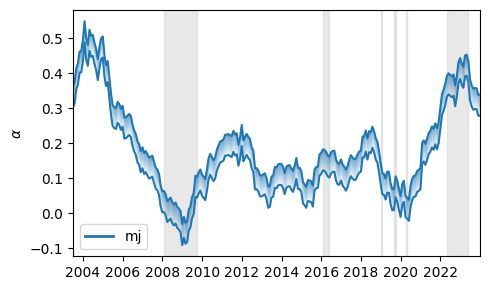

In [ ]:
######################
# COMPUTE TIME VARYING PERFORMANCE (=metrica rolling)
######################

type_port='long_short'
#EW portfolio of interest
EW_portfolio=MJ_portfolios['mj'][type_port]
EW_data=df_mkt.merge(EW_portfolio.reset_index(),on='medate',how='outer').set_index('medate')[['Mkt_RF',type_port]]
EW_data=EW_data.rename(columns={'Mkt_RF':'mkt_excess',type_port:'port_excess'})

#VW portfolio of interest  ###### MODIFY HERE!!!!!!!!!!!!!
VW_portfolio=MJ_portfolios['mj'][[type_port]]-0.005                                                                         ############<---------------
VW_data=df_mkt.merge(VW_portfolio.reset_index(),on='medate',how='outer').set_index('medate')[['Mkt_RF',type_port]]
VW_data=VW_data.rename(columns={'Mkt_RF':'mkt_excess',type_port:'port_excess'})

## COMPUTE PERFORMANCE
perfs=compute_portfolio_performance(EW_data, window_size=36)
wperfs=compute_portfolio_performance(VW_data, window_size=36)


######################
# PLOT TIME VARYING PERFORMANCE (visualizzo sia ew che vw)
######################
## --> le differenze le vedo con il gradiente

import matplotlib.dates as mdates

performance='alpha' #['Av_ret', 'Vol_ret', 'Sharpe_ratio', 'beta', 'Treynor_ratio', 'Information_ratio', 'alpha', 'Sortino_ratio', 'Max_Drawdown']

names={'Av_ret':'Excess return',
      'Vol_ret': 'Excess Volatility',
      'Sharpe_ratio': 'Sharpe Ratio',
      'beta': r'$\beta$',
      'Treynor_ratio': 'Treynor Ratio',
      'Information_ratio': 'Information Ratio',
      'alpha': r'$\alpha$',
      'Sortino_ratio': 'Sortino Ratio',
      'Max_Drawdown': 'Maximum Drawdown'}


# Plot shaded area between the two series for each method with gradient (no borders)
num_layers = 20  # Number of layers in the gradient

fig, ax = plt.subplots(figsize=(5, 3))

# Find regions with at least two consecutive regime = -1
consecutive_regions = []
start_idx = None
for i in range(len(df_mkt)):
   # Start of a new potential region
   if df_mkt['regime'].iloc[i] == -1.0 and start_idx is None:
       start_idx = i
  
   # End of a potential region
   elif df_mkt['regime'].iloc[i] != -1.0 and start_idx is not None:
       # Check if we have at least 2 consecutive -1 values
       if i - start_idx >= 2:
           consecutive_regions.append((start_idx, i-1))
       start_idx = None
  
   # Handle the last region if it extends to the end of the data
   if i == len(df_mkt) - 1 and start_idx is not None:
       if i - start_idx >= 1:  # At least 2 points total
           consecutive_regions.append((start_idx, i))


# Add background shadowing for the consecutive regions
for start, end in consecutive_regions:
   start_date = df_mkt['medate'].iloc[start]
   end_date = df_mkt['medate'].iloc[end]
   ax.axvspan(start_date, end_date, color='lightgrey', alpha=0.5)

# Plot the lines
ax.plot(perfs.index, perfs[performance], color='C0')  # solid line for lower edge
ax.plot(perfs.index, wperfs[performance], color='C0', linewidth=1.5)  # solid line for upper edge

initial_alpha=0.7

# Create gradient
for i in range(num_layers):
   alpha = initial_alpha - (initial_alpha * i / num_layers)  # Decreasing alpha from 0.5 to 0
   interp = i / num_layers
   y_bottom = perfs[performance] + (wperfs[performance] - perfs[performance]) * interp
   y_top = perfs[performance] + (wperfs[performance] - perfs[performance]) * (interp + 1/num_layers)
   ax.fill_between(perfs.index, y_bottom, y_top, color='C0', alpha=alpha, linewidth=0)

# Add legend entries for the methods
ax.plot([], [], color='C0', label='mj', linewidth=2)

# Set x-axis limits to exactly match the data range
ax.set_xlim(min(perfs.loc[perfs['Av_ret'].notna()].index),max(perfs.loc[perfs['Av_ret'].notna()].index))


# Add labels and title
#plt.title('Rolling Sharpe Ratio: EW vs VW')
ax.set_ylabel(names[performance]) #r'Jensen $\alpha$' , 'Information Ratio'
plt.legend()
plt.tight_layout()
#plt.savefig(f'fixed_results/Rolling{performance}_{port}_{window}.pdf')
plt.show()

In [24]:
######################
# COMPUTE AVG TIME VARYING INDICATORS
######################

## --> ogni finestra di 3 anni ha prodotto un rendimento annuo del 18.47%
## --> io sopra faccio media su (esempio) 72 mesi in unico blocco, qua fa 1-36, 2-37,...,37-72, e poi fa la media delle medie.

# Compute perfromance in different market regimes
EW_TV_performances = compare_bull_bear_market_indicators(EW_data, window_size=window,port=port)['comparison']
VW_TV_performances = compare_bull_bear_market_indicators(VW_data, window_size=window,port=port)['comparison']

pd.DataFrame(EW_TV_performances)

,Av_ret,Vol_ret,Sharpe_ratio,beta,Treynor_ratio,Information_ratio,alpha,Sortino_ratio,Max_Drawdown
avg,0.184725,0.133722,1.299281,-0.263950,-0.911316,0.336838,0.204099,3.873317,0.113987
bull,0.191516,0.133525,1.380104,-0.264195,-0.766884,0.318131,0.212802,4.162795,0.106238
bear,0.157284,0.134522,0.972689,-0.262961,-1.494942,0.412428,0.168933,2.703587,0.145300


In [20]:
# a-jensen + modificare confronti (1vs 10, ls vs ls)
#ttest-rel al posto di wilcoxon
